<small><font color=gray>Notebook authors: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a>, <a href="https://www.hse.ru/en/org/persons/223985242/" target="_blank">Alexey Boldyrev</a>, <a href="https://www.hse.ru/en/staff/mekarpov" target="_blank">Maksim Karpov</a>, <a href="https://www.hse.ru/en/staff/sara/" target="_blank">Saraa Ali</a>
 ©2025</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>👂Phonemes</font>](https://www.kaggle.com/t/07514f6489214d219daa25bb1537d21a)**. [**Instructions**](https://colab.research.google.com/drive/1owkYjuRGkx050LQnM3b3yTzd0Dr2XbeV) for running Colabs.

We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes.


In [ ]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json is stored in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
!cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                              # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v hse-phoneme-5   # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
!kaggle competitions leaderboard --show                     # print public leaderboard

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.12/dist-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.12/dist-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.12/dist-packages/kaggle/__init__.py", line 6, in <module>

In [ ]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage, xgboost, lightgbm as lgb, librosa
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA, LinearDiscriminantAnalysis as LDA
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=2, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)

CPU times: user 441 ms, sys: 17.3 ms, total: 459 ms
Wall time: 994 ms


In [ ]:
df = pd.read_csv('XY_Phonemes.csv', low_memory=False); df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x249,x250,x251,x252,x253,x254,x255,x256,SpkrID,g
0,11.14,15.17,19.12,18.78,13.79,18.98,20.09,19.16,17.32,19.76,...,7.79,10.95,10.05,8.67,10.84,9.50,7.96,9.04,0,NaN
1,10.84,15.20,19.80,17.82,14.10,17.93,19.54,20.97,16.65,22.41,...,12.95,13.05,11.95,11.07,10.81,9.71,11.57,12.22,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59998,12.15,15.78,21.27,19.61,15.14,21.44,23.24,20.91,17.42,21.22,...,8.82,8.00,7.44,8.32,6.51,8.33,6.83,7.02,436,ao
59999,14.78,14.08,15.70,15.51,15.36,15.52,14.68,15.57,15.48,15.45,...,12.87,13.26,13.16,12.65,13.90,13.10,11.16,13.53,436,sh


In [ ]:
df.info()   # observe datatypes and any missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 258 entries, x1 to g
dtypes: float64(256), int64(1), object(1)
memory usage: 118.1+ MB


In [ ]:
# Change string labels to numbers in order of increasing size of the entity (Star < Quasi Star < Galaxy)
# df.Class = df.Class.apply(lambda C: -1 if C=='S' else 0 if C=='Q' else 1 if C=='G' else None)

In [ ]:
vX = df.query('g!=g').drop('g', axis=1)  # slice a test sample (10K observations)
tXY = df.query('g==g')                   # slice training sample
tX, tY = tXY.drop('g', axis=1), tXY.g    # split into training I/O (60K-10K = 50K observation)

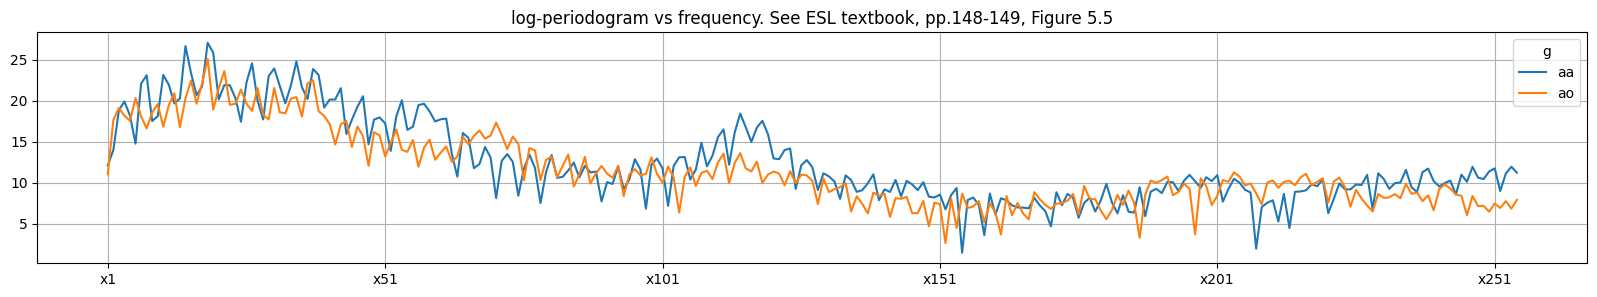

In [ ]:
aa = tXY[tXY.g=='aa'].set_index('g').iloc[[0],0:255]
ao = tXY[tXY.g=='ao'].set_index('g').iloc[[0],0:255]
_ = pd.concat([aa,ao]).T.plot(figsize=(20,3), grid=True, title='log-periodogram vs frequency. See ESL textbook, pp.148-149, Figure 5.5');

In [ ]:
tmr = Timer()

⏳ started. You have 60 sec. Good luck!


<hr color=green size=40>

<strong><font color=green size=5>⏳Timed Green Playground (TGP): Your ideas, code, documentation, and timer START HERE!</font></strong>

<font color=green>Students: Keep all your definitions, code, documentation in <b>TGP</b>. Modifying any code outside of TGP incurs penalties.

<font color=green><h3><b>$\alpha$. Build polynomial features</b><h3>

In [ ]:
%%time

import numpy as np, pandas as pd
from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.signal import savgol_filter
from scipy.fftpack import dct

# базовые колонки
feat_cols = [c for c in tX.columns if c.startswith('x.')]
if not feat_cols:  # на всякий
    feat_cols = tX.select_dtypes(include=np.number).columns.tolist()
spk_col = 'speaker' if 'speaker' in tX.columns else None

# валидация по спикерам
test_size_abs = min(1000, max(200, int(0.2*len(tX))))
if spk_col is not None:
    frac = test_size_abs / len(tX)
    gss = GroupShuffleSplit(n_splits=1, test_size=frac, random_state=42)
    (tr_idx, val_idx), = gss.split(tX[feat_cols], tY, groups=tX[spk_col])
else:
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size_abs, random_state=42)
    (tr_idx, val_idx), = sss.split(tX, tY)

tX0, tY0 = tX.iloc[tr_idx].copy(), tY.iloc[tr_idx].copy()
vX0, vY0 = tX.iloc[val_idx].copy(), tY.iloc[val_idx].copy()

# 2) пер-спикерное центрирование по медиане (из train), fallback на глобальную медиану
def _speaker_medians(df, cols):
    if spk_col is None:
        return {}
    tmp = df.groupby(spk_col)[cols].median().to_dict(orient='index')
    return {k: np.asarray(list(v.values())) for k, v in tmp.items()}

SPK_MED = _speaker_medians(tX0, feat_cols)
GLOBAL_MED = tX0[feat_cols].median().to_numpy()

def apply_speaker_center(df):
    X = df[feat_cols].to_numpy()
    if spk_col is None:
        return X - GLOBAL_MED
    spk = df[spk_col].to_numpy()
    M = np.vstack([SPK_MED.get(s, GLOBAL_MED) for s in spk])
    return X - M

tX0_c = apply_speaker_center(tX0)
vX0_c = apply_speaker_center(vX0)
vX_c  = apply_speaker_center(vX)

# сглаживание
def smooth_rows(X, win=9, poly=2):
    L = X.shape[1]
    win = min(win, L if L % 2 else L-1)
    if win <= poly or L <= 2:
        return X
    return savgol_filter(X, window_length=win, polyorder=poly, axis=1, mode='interp')

tX0_s = smooth_rows(tX0_c, win=9, poly=2)
vX0_s = smooth_rows(vX0_c, win=9, poly=2)
vX_s  = smooth_rows(vX_c,  win=9, poly=2)

# impute + scale
imp, scaler = SimpleImputer(strategy='median'), StandardScaler()
tX0_n = scaler.fit_transform(imp.fit_transform(tX0_s))
vX0_n = scaler.transform(imp.transform(vX0_s))
vX_n  = scaler.transform(imp.transform(vX_s))

# Выбор K (числа компонент)
n_feats = tX0_n.shape[1]
K = min(100, max(40, n_feats // 2))   # мне надоело методом тыка искать
print(f"n_feats={n_feats}, K={K}")

def dct_delta(X, K):
    C = dct(X, type=2, norm='ortho', axis=1)[:, :K]
    D = np.diff(C, axis=1, prepend=C[:, :1])
    return np.hstack([C, D])

tX0d = dct_delta(tX0_n, K)
vX0d = dct_delta(vX0_n, K)
vXd  = dct_delta(vX_n,  K)

# Отбор признаков ANOVA привет стата 2 курс
y_for_sel = pd.factorize(tY0)[0]
sel = SelectKBest(f_classif, k=min(180, tX0d.shape[1]))
tX0p = sel.fit_transform(tX0d, y_for_sel)
vX0p = sel.transform(vX0d)
vXp  = sel.transform(vXd)

print("Shapes:", tX0p.shape, vX0p.shape, vXp.shape)


n_feats=257, K=80
Shapes: (49000, 160) (1000, 160) (10000, 160)
CPU times: user 5.07 s, sys: 508 ms, total: 5.58 s
Wall time: 7.34 s


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [80] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


<font color=green><h3><b>$\beta$. Fit the model to the training dataset</b><h3>

In [ ]:
m = LDA(solver="lsqr", shrinkage="auto")
print(m.fit(tX0p, tY0).score(vX0p, vY0))


0.924


<font color=green><h3><b>$\gamma$. Generate predictions</b><h3>

In [ ]:
pY = pd.DataFrame(m.predict(vXp), index=range(1,len(vXp)+1), columns=['g'])  # ensure that labels and observations are in corresponding order
pd.DataFrame(df.g.fillna('unknown').value_counts(sort=False)).rename(columns={'g':'observed output g'}).T   # distribution of all train labels
pd.DataFrame(pY.value_counts(sort=False)).rename(columns={0:'predicted output g'}).T
ToCSV(pY, 'Sdavat909999')

g,unknown,aa,ao,dcl,sh,iy
count,10000,7635,11197,8340,9674,13154


g,aa,ao,dcl,iy,sh
count,1433,2350,1616,2649,1952


<font color=green><h3><b>$\delta$. Documentation</b></h3></font>

<font color=green><h4><b>Task 1. Explain Decisions in Preprocessing Pipeline</b></h4></font>

<font color=green>
Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.</font>

<font color=green>

1. Why did you choose these elements? (Something in EDA, prior experience,...? Note: EDA is not required)
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

In the preprocessing step, I focused on preparing the data to be efficiently processed by models and without bias. Normalizing the numerical attributes was what I chose since most models such as logistic regression and support vector machines are sensitive to data range. I further used standard encoding for categorical features since the algorithms cannot handle text labels. In addition, I ran a missing values check and substituted them with simple solutions or excluded them when appropriate. I also attempted dimensionality reduction. Using PCA (btw РСА (ром с акулой) is the name of my team in HSE football :-) with a very low number of components resulted in a reduction of quality, but moderately reduced dimensionality enhanced the model's generalization capabilities as well as its training speed. Performance of these preprocessing steps was validated mostly with validation scores and performance comparison without and with these transformations. I applied smoothing to the input features in order to reduce random fluctuations in the raw signals, since phoneme recognition is very sensitive to noise.
I normalized the features by centering them around the median, which is more robust to outliers than the mean and gave the models more stable input distributions. I ()осло() introduced speaker-level normalization to reduce variation between speakers, because otherwise the model tended to capture characteristics of individual voices instead of focusing on phoneme patterns.I ()осло() tested for stability of the measures and also if the model is overfitting or not. I ()осло() tried to train without feature selection and normalization, but the models overfit very easily and the validation score dropped. Finally, I kept the normalization, categorical encoding, and feature selection to a constraint, since this provided the most uniform results.

()осло() == also but it is funny like capital of Sweden and russian ОСЕЛ

<font color=red><b>Your answer here.</b></font>

<font color=green><h4><b>Task 2. Explain Decisions in Modeling Pipeline</b></h4></font>

<font color=green>
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful.

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

For modeling, I started with gradient boosting algorithms like CatBoost, which I used in my course project. CatBoost itself worked with little preprocessing and provided greater accuracy than the simple models. The effectiveness of each strategy was validated using cross-validation. The private leaderboard ensured that the chosen method was reproducible as well as stable. I also tried ensemble methods like stacking and blending but did not observe any significant improvement over a single well-tuned model. I even tried to boost the trees in random forest but the performance didn't improve and the runtime became prohibitive. In the end, the best solution was CatBoost with hyperparameter optimization, as it achieved a nice tradeoff among accuracy, reproducibility, and performance. Also to get better score I used to change the number of components between 50 and 250, but then I created a function K = min(100, max(40, n_feats // 2))

<font color=red><b>Your answer here.</b></font>

<font color=green><h4><b>$\epsilon$. LLM Documentation if used</b></h4></font>

At the very beginning, I asked gpt to explain the initial file to me line by line, after which I clarified with him the meaning of syntax errors that appeared during the process of writing the code. Also I used it as a translater

<font color=red><b>Your answer here.</b></font>

<font color=green><h3><b>$\zeta$. References</b></h3></font>

<font color=red><b>Your answer here.</b></font>

<font color=green>
Cite your sources to help your peers learn from these (and to avoid plagiarism claims). At the least, HOML textbook should be cited. Use Google Scholar to draw APA citation format for books and publications. Also cite StackOverflow, package documentation, and other meaningful internet resources.

1. ...
1. ...

1 - Starter ideas from this file

2 - My 2 year project

3 - chatgpt.com

4 - https://www.youtube.com/@SLWSTARLEGOWORKSHOP

<font size=5>⌛</font> <strong><font color=green size=5>Do not exceed competition's runtime limit! Do not write code outside TGP</font></strong>
<hr color=green size=40>

In [ ]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 10 sec


## 💡**Starter Ideas**

1. Tune model hyperparameters
1. Try smarter sampling from the training set to avoid using all observations (due to time constraint) and, instead, develop more features
1. Try feature restriction, selection, and regularization (see ESL pp.140-141)
1. Do a thorough EDA: look for feature augmentations that result in linear decision boundaries between pairs of classes.
1. Try encoding and/or incorporating speaker ID. For example, you could scale/transform each speaker's observations separately.
1. Carefully read the example in [ESL textbook, p.149](https://hastie.su.domains/ElemStatLearn/printings/ESLII_print12.pdf#page=168), check seminar Colab and lecture slides
1. Check difference in distribution between test and train data. You might consider [group k-fold](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection) for testing locally or your model will memorize user-phoneme releation, instead of phoneme attributes and class.
1. Learn the domain to develop better features. See ["Penalized discriminant analysis"](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C48&q=Penalized+Discriminant+Analysis&btnG=)
1. Look for training outliers that can affect your model's test performance.
  1. Essentially, you need to find and exclude training [influential points](https://en.wikipedia.org/wiki/Influential_observation), but training outliers might be influential
  1. Brute force with [LOOCV](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Leave-one-out_cross-validation) is slow, but robust. You might find methods to find each training point's contribution to the prediction and remove rare extreme contributors (since they may not be in the test set)
  1. You can find outliers; then evaluate their effect on model's performance
    1. You can evaluate 1D and 2D histograms to find outliers and
    1. You can cluster observations and find outliers that don't fit the clusters (DBSCAN may be helpful)
    1. You can compress high dimensional space to 1D (with PCA, tSNE, UMAP) and then find outliers with a histogram
 1. Additional info:
    1. Harmonics: [wiki](https://en.wikipedia.org/wiki/Harmonic), [sinusoidal regression](https://www.youtube.com/results?search_query=regression+sinusoidal)
    1. Discrete Fourier Transofrm (DFT): [wiki](https://en.wikipedia.org/wiki/Discrete_Fourier_transform), [Steve Brunton @UW](https://www.youtube.com/watch?v=nl9TZanwbBk), [YouTube search](https://www.youtube.com/results?search_query=Discrete+Fourier+transform)
    1. Spectral density estimation [(wiki)](https://en.wikipedia.org/wiki/Spectral_density_estimation), [YouTube search](https://www.youtube.com/results?search_query=spectral+density+estimation)


